# EDA and preprocessing of the totalVI_10x dataset

In [50]:
import anndata as ad
import pandas as pd
import numpy as np
import scanpy as sc
import seaborn as sns
import anndata2ri

sc.settings.verbosity = 3  # show info messages
sc.set_figure_params(figsize=(5, 3))  # set figsize for plots


# GEX preprocessing

In [51]:
data = ad.read_h5ad("data/raw/gex_adt/totalVI_10x_gex.h5ad")

In [52]:
data

AnnData object with n_obs × n_vars = 6838 × 16659
    obs: 'n_genes', 'percent_mito', 'n_counts'
    var: 'n_cells', 'highly_variable'
    uns: 'dataset_id', 'organism'

## Basic QC

### Filter counts and genes

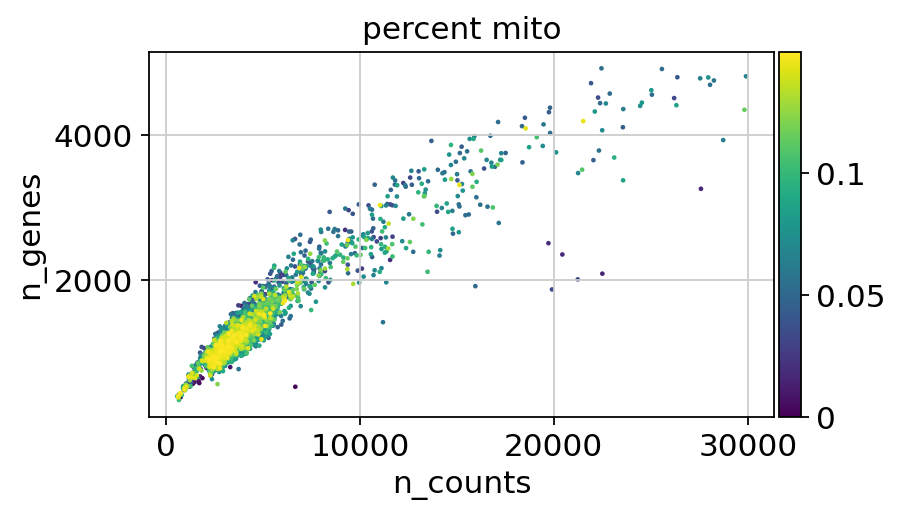

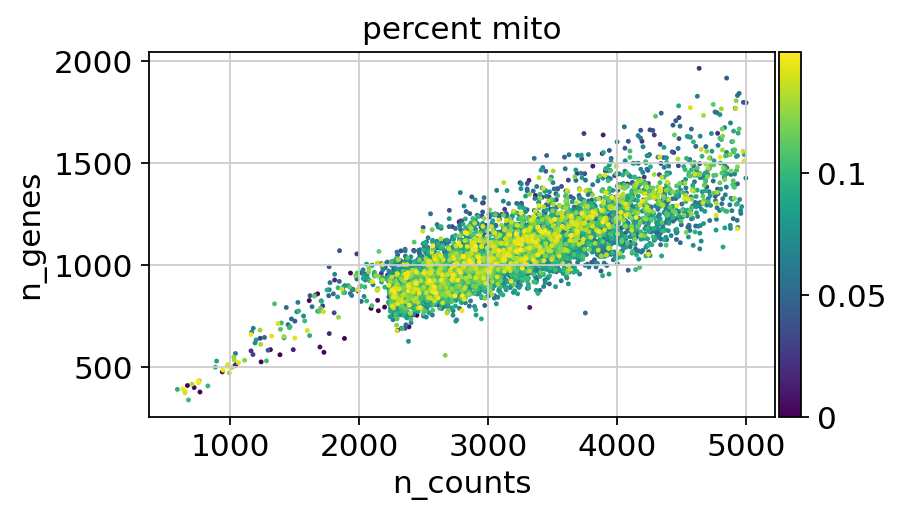

In [53]:
p1 = sc.pl.scatter(data, 'n_counts', 'n_genes', color='percent_mito')
p2 = sc.pl.scatter(data[data.obs['n_counts'] < 5000], 'n_counts', 'n_genes', color='percent_mito')

There is strange cells population with n_counts < 2300. Let's find this threshold.

/home/simon/miniconda3/envs/nips/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


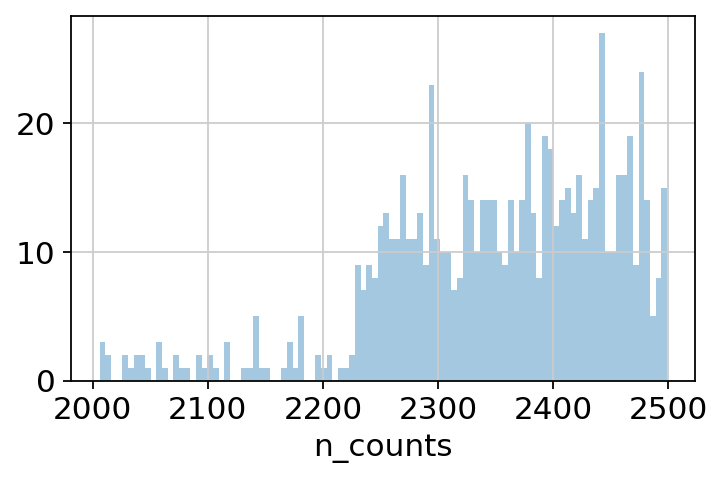

In [54]:
zoomed_cells = data.obs['n_counts']
zoomed_cells = zoomed_cells[zoomed_cells<2500]
zoomed_cells = zoomed_cells[zoomed_cells>2000]
p3 = sns.distplot(zoomed_cells, kde=False, bins=100)

We will filter cells with n_counts < 2200.

In [55]:
sc.pp.filter_cells(data, min_counts=2200)

filtered out 167 cells that have less than 2200 counts


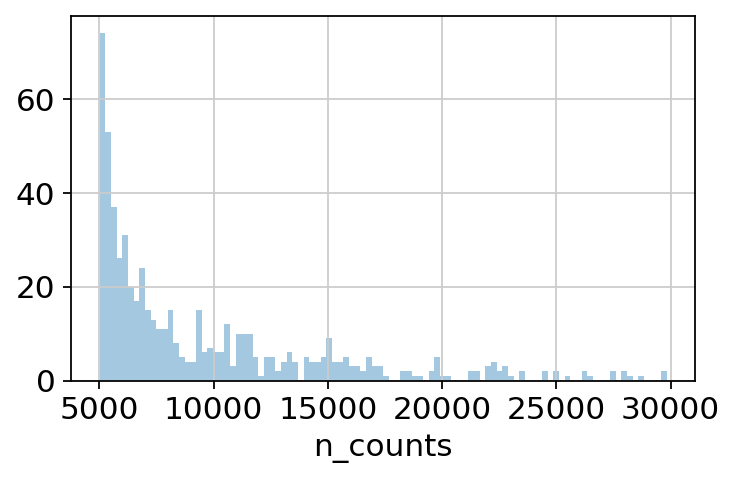

In [56]:
p4 = sns.distplot(data.obs['n_counts'][data.obs['n_counts'] > 5000], kde=False, bins=100)

We will filter out cells with n_counts > 10000

In [57]:
sc.pp.filter_cells(data, max_counts=10000)

filtered out 199 cells that have more than 10000 counts


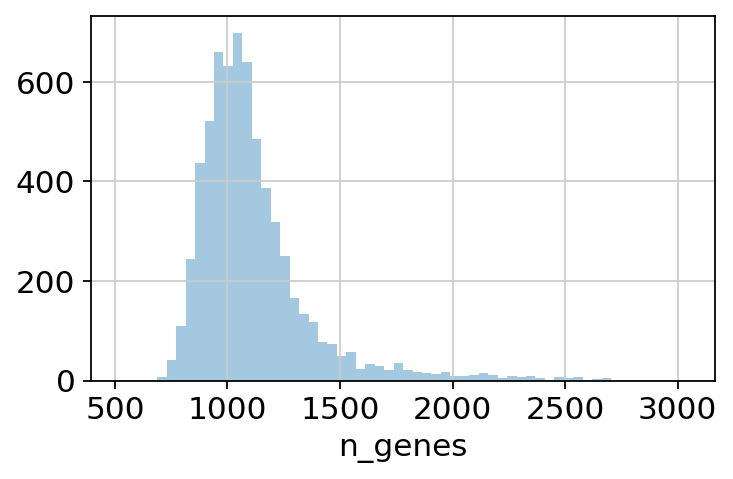

In [58]:
p6 = sns.distplot(data.obs['n_genes'], kde=False, bins=60)

### Mitochondria counts

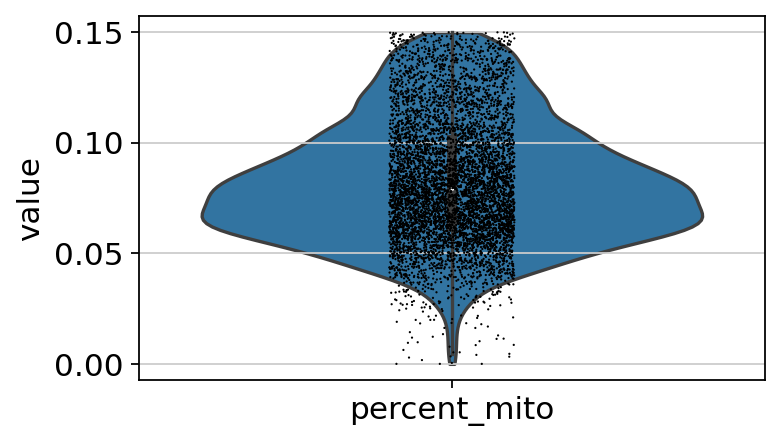

In [59]:
# Let's see percent of counts from mitochondria genes
sc.pl.violin(data, ['percent_mito'], inner='box')

It's already good enough, but here how you could filter cells

In [60]:
THRESHOLD = 0.2
data = data[data.obs["percent_mito"] < THRESHOLD]

### Minimal number of cells expressing a gene

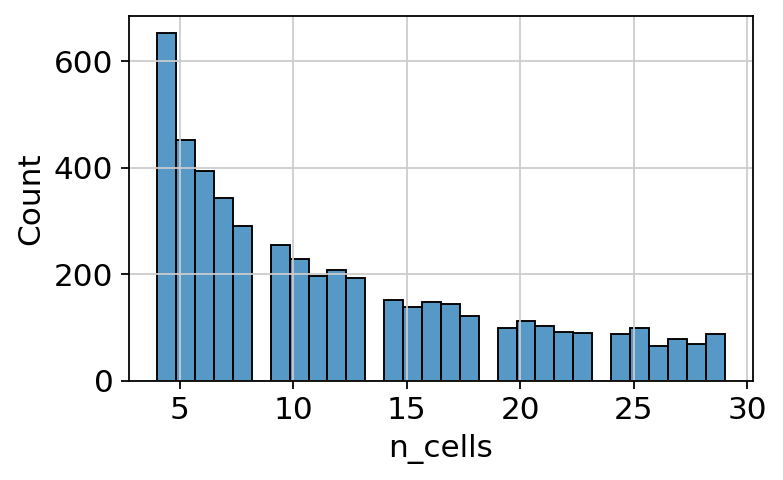

In [61]:
# Let's see how many cells express some genes
plot = sns.histplot(data.var['n_cells'][data.var['n_cells'] < 30], bins=30)

We see, that each gene has been expressed at least at 4 cells. Good.

normalizing counts per cell
    finished (0:00:00)


/home/simon/miniconda3/envs/nips/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:155: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


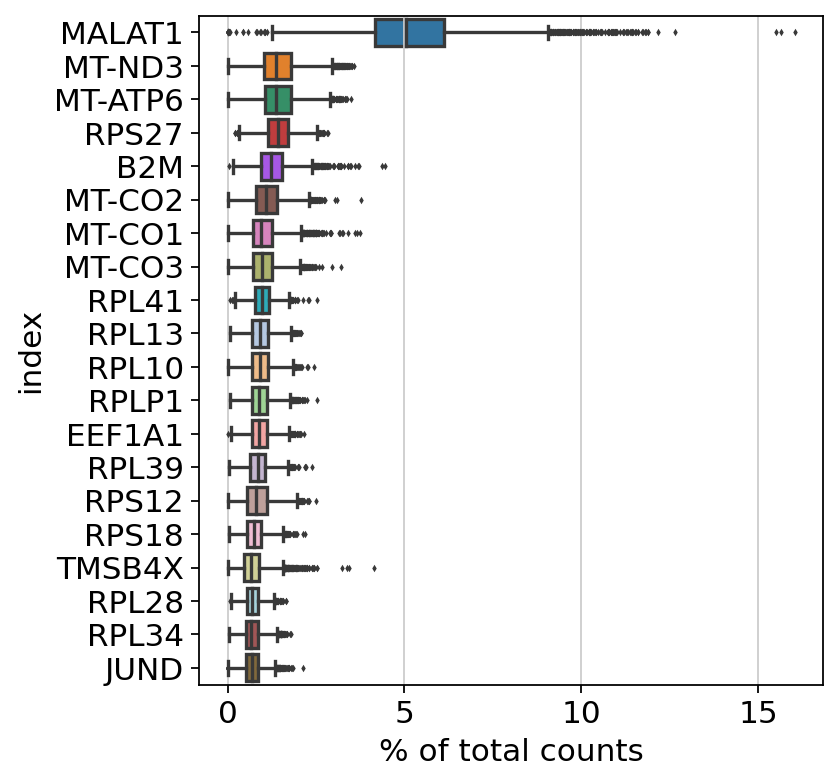

In [62]:
# Here is the highest expressed genes
sc.pl.highest_expr_genes(data, n_top=20, )

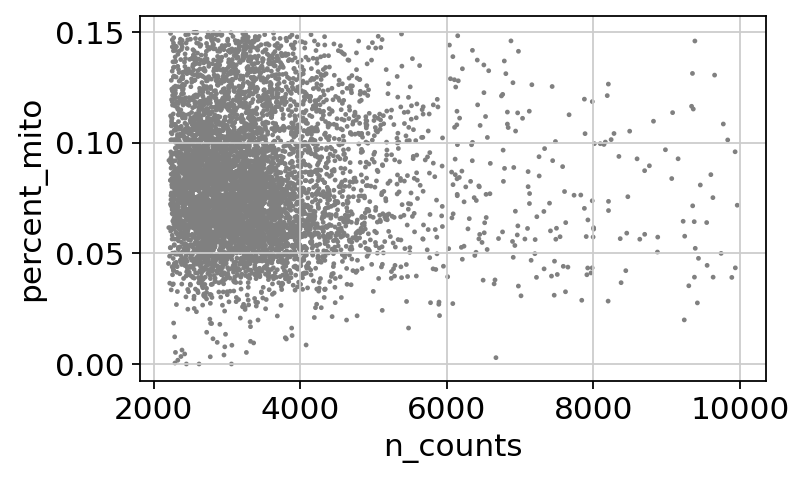

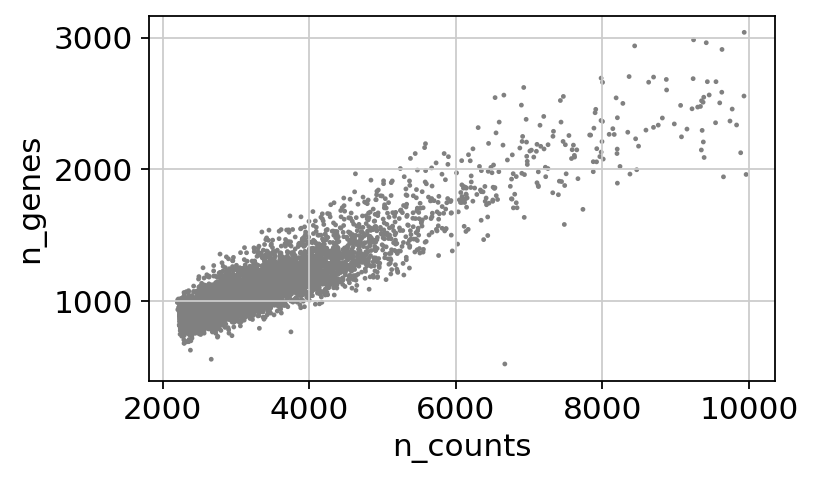

In [63]:
sc.pl.scatter(data, x='n_counts', y='percent_mito')
sc.pl.scatter(data, x='n_counts', y='n_genes')

### Normalization

In [64]:
data

AnnData object with n_obs × n_vars = 6472 × 16659
    obs: 'n_genes', 'percent_mito', 'n_counts'
    var: 'n_cells', 'highly_variable'
    uns: 'dataset_id', 'organism'